# Projeto 9 - Regressão Carros Usados - Validação Cruzada

## 1. Importando bibliotecas

In [1]:
import pandas as pd
import torch
import numpy as np
import seaborn as sns
from torch import nn, optim
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from skorch import NeuralNetRegressor
from sklearn.model_selection import cross_val_score


## 2. Importando a base de dados

In [2]:
np.random.seed(123)
torch.manual_seed(123)

In [3]:
base = pd.read_csv("data/autos.csv", encoding="ISO-8859-1")

In [4]:
base.head(5)

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
base["price"]

0           480
1         18300
2          9800
3          1500
4          3600
          ...  
371523     2200
371524     1199
371525     9200
371526     3400
371527    28990
Name: price, Length: 371528, dtype: int64

In [6]:
base.columns

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object')

In [7]:
base.drop(columns=["dateCrawled", "dateCreated", "nrOfPictures", "postalCode", "lastSeen"], inplace=True)

In [8]:
base.shape

(371528, 15)

In [9]:
base.head()

,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
1,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
2,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
3,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein


In [10]:
base["name"].value_counts()

name
Ford_Fiesta                                              657
BMW_318i                                                 627
Opel_Corsa                                               622
Volkswagen_Golf_1.4                                      603
BMW_316i                                                 523
                                                        ... 
Audi_A4_Avant_Klima_Gruene_Plakette_TÜV_&AU_NEU_XENON      1
Renault_clio_in_gold_450VB_!!                              1
Fiat_Doblo_1.6_Multijet                                    1
Renault_Laguna_1                                           1
BMW_M135i_vollausgestattet_NP_52.720____Euro               1
Name: count, Length: 233531, dtype: int64

In [11]:
base.drop("name", axis=1, inplace=True)

In [12]:
base.head()

,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
1,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
2,privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
3,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein


In [13]:
base.seller.value_counts()

seller
privat        371525
gewerblich         3
Name: count, dtype: int64

In [14]:
base.drop("seller", axis=1, inplace=True)

In [15]:
base.head()

,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
1,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
2,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
3,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein


In [16]:
base.offerType.value_counts()

offerType
Angebot    371516
Gesuch         12
Name: count, dtype: int64

In [17]:
base.drop("offerType", axis=1, inplace=True)

In [18]:
base.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
1,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
2,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein


In [19]:
i1 = base.loc[base.price <= 10]
i1.shape

(12118, 12)

In [20]:
base = base[base.price > 10]

In [21]:
base.shape

(359410, 12)

In [22]:
i2 = base.loc[base.price > 350000]
i2.shape

(115, 12)

In [23]:
base = base[base.price < 350000]

In [24]:
base.shape

(359291, 12)

<Axes: >

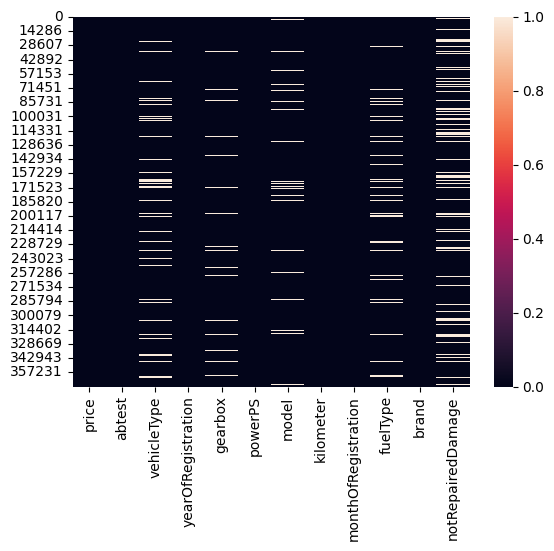

In [25]:
sns.heatmap(base.isnull())

In [26]:
base.loc[pd.isnull(base["vehicleType"])].shape

(33546, 12)

In [27]:
base["vehicleType"].value_counts() #limousine

vehicleType
limousine     93614
kleinwagen    78014
kombi         65921
bus           29699
cabrio        22509
coupe         18386
suv           14477
andere         3125
Name: count, dtype: int64

In [28]:
base.loc[pd.isnull(base["gearbox"])].shape

(17236, 12)

In [29]:
base["gearbox"].value_counts() #manuell

gearbox
manuell      266547
automatik     75508
Name: count, dtype: int64

In [30]:
base.loc[pd.isnull(base["model"])].shape

(17967, 12)

In [31]:
base["model"].value_counts() #golf

model
golf               28989
andere             25560
3er                19905
polo               12604
corsa              12149
                   ...  
serie_2                8
rangerover             6
serie_3                3
serie_1                1
discovery_sport        1
Name: count, Length: 251, dtype: int64

In [32]:
base.loc[pd.isnull(base["fuelType"])].shape

(29391, 12)

In [33]:
base["fuelType"].value_counts() #benzin

fuelType
benzin     217582
diesel     106002
lpg          5222
cng           557
hybrid        271
andere        165
elektro       101
Name: count, dtype: int64

In [34]:
base.loc[pd.isnull(base["notRepairedDamage"])].shape

(65986, 12)

In [35]:
base["notRepairedDamage"].value_counts()

notRepairedDamage
nein    259301
ja       34004
Name: count, dtype: int64

In [36]:
valores = {"vehicleType": "limousine",
           "gearbox": "manuell",
           "model": "golf",
           "fuelType": "benzin",
           "notRepairedDamage": "nein"
}

In [37]:
base = base.fillna(value = valores)

In [38]:
base.isna().sum()

price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dtype: int64

In [39]:
preco_real = base["price"]

In [40]:
previsores = base.drop(columns="price")

In [41]:
previsores.columns

Index(['abtest', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS',
       'model', 'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage'],
      dtype='object')

In [42]:
onehotencoder = ColumnTransformer(transformers=[("OneHot", 
                                                 OneHotEncoder(), 
                                                 [0,1,3,5,8,9,10])],
                                                 remainder="passthrough"
                                                )

In [43]:
previsores = onehotencoder.fit_transform(previsores).toarray()

In [44]:
previsores.shape

(359291, 316)

In [45]:
previsores = np.array(previsores)
preco_real = np.array(preco_real)

In [46]:
previsores = previsores.astype('float32')
preco_real = preco_real.astype('int64')

## 3. Construção do modelo

In [47]:
class regressao_torch(nn.Module):
    def __init__(self):
        super().__init__()

        self.dense0 = nn.Linear(316, 158)
        self.activation0 = nn.ReLU()
        
        self.dense1 = nn.Linear(158, 158)
        self.activation1 = nn.ReLU()
        
        self.dense2 = nn.Linear(158, 1)

    def forward(self, X):
        X = self.dense0(X)
        X = self.activation0(X)

        X = self.dense1(X)
        X = self.activation1(X)

        X = self.dense2(X)
        return X

In [48]:
regressao_sklearn = NeuralNetRegressor(module=regressao_torch,
                                          criterion=torch.nn.L1Loss,
                                          optimizer=torch.optim.Adam,
                                          max_epochs=100,
                                          batch_size=300,
                                          train_split=False)

## 4. Validação Cruzada

In [49]:
resultados = cross_val_score(regressao_sklearn, 
                             previsores, 
                             preco_real, 
                             cv = 10, 
                             scoring = 'neg_mean_absolute_error')

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     4566.8289  1.4805


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([261])) that is different to the input size (torch.Size([261, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     4541.4288  1.4577
      3     4539.8249  1.5578
      4     4539.2682  1.4397
      5     4538.5074  1.4484
      6     4536.8198  1.4442
      7     4536.6350  1.4413
      8     4536.8699  1.4342
      9     4536.1486  1.4866
     10     4536.3173  1.4270
     11     4536.1091  1.4712
     12     4535.9997  1.6253
     13     4535.9006  1.4400
     14     4535.6416  1.4291
     15     4535.5743  1.3985
     16     4535.8022  1.4285
     17     4535.8238  1.4534
     18     4535.6079  1.4537
     19     4535.5811  1.4276
     20     4535.6685  1.4211
     21     4535.3832  1.4282
     22     4535.4170  1.4095
     23     4535.2759  1.4273
     24     4535.2845  1.4117
     25     4535.3845  1.4091
     26     4535.2180  1.4134
     27     4535.4418  1.4533
     28     4535.2858  1.4503
     29     4535.3066  1.4638
     30     4535.2786  1.7016
     31     4535.1846  1.4540
     32     4535.3004  2.3195
     33     4535.1715  1.8586
     34     4535.2060  2.0768
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     4559.1576  1.4149


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([262])) that is different to the input size (torch.Size([262, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     4539.4903  1.4229
      3     4536.6547  1.4003
      4     4532.5075  1.4200
      5     4532.4199  1.4283
      6     4532.0120  1.5104
      7     4531.6952  1.4076
      8     4530.9811  1.4327
      9     4530.6939  1.4218
     10     4530.8785  1.4226
     11     4530.3102  1.4047
     12     4530.4615  1.4036
     13     4530.4886  1.4089
     14     4530.3039  1.4075
     15     4530.3515  1.4430
     16     4529.9045  1.4101
     17     4529.5383  1.4519
     18     4529.8963  1.4048
     19     4529.8724  1.5584
     20     4529.6677  1.4345
     21     4529.5994  1.4200
     22     4529.8017  1.4238
     23     4529.5315  1.4085
     24     4529.6743  1.4073
     25     4529.6403  1.4556
     26     4529.4836  1.5230
     27     4529.5679  1.4709
     28     4529.5363  1.4542
     29     4529.5345  1.4975
     30     4529.4924  1.5483
     31     4529.4409  1.5281
     32     4529.3909  1.6779
     33     4529.3053  1.4408
     34     4529.2985  1.4319
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     4560.2440  1.4341


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([262])) that is different to the input size (torch.Size([262, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     4533.9099  1.4228
      3     4531.5563  1.4385
      4     4530.4457  1.4482
      5     4529.5230  1.4804
      6     4529.1783  1.5757
      7     4528.2240  1.4157
      8     4527.9394  1.4341
      9     4527.6303  1.4155
     10     4528.0229  1.4231
     11     4527.1734  1.4574
     12     4527.7089  1.4681
     13     4527.3626  1.4194
     14     4526.9904  1.4213
     15     4526.9142  1.4107
     16     4527.2595  1.4092
     17     4527.0207  1.4211
     18     4527.1966  1.3962
     19     4527.1078  1.4239
     20     4526.9887  1.4304
     21     4527.1004  1.4261
     22     4526.9072  1.4433
     23     4526.8320  1.4285
     24     4526.8312  1.4234
     25     4526.8020  1.3879
     26     4526.8012  1.4082
     27     4526.7395  1.4375
     28     4526.8057  1.4153
     29     4526.8090  1.4109
     30     4526.7295  1.4194
     31     4526.7804  1.4109
     32     4526.6699  1.4237
     33     4526.6708  1.4298
     34     4526.6383  1.4369
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     4560.3895  1.4540


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([262])) that is different to the input size (torch.Size([262, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     4537.6150  1.4457
      3     4535.2297  1.4454
      4     4535.2962  1.4554
      5     4534.7219  1.4065
      6     4533.9962  1.4527
      7     4532.6505  1.4249
      8     4531.8479  1.4210
      9     4531.4821  1.4374
     10     4531.2364  1.4204
     11     4530.8880  1.4358
     12     4530.9414  1.4370
     13     4530.6177  1.4606
     14     4530.3805  1.4523
     15     4530.3515  1.4491
     16     4530.5272  1.4390
     17     4530.7460  1.4550
     18     4530.5016  1.4732
     19     4530.5279  1.4326
     20     4530.4135  1.4316
     21     4530.2245  1.4257
     22     4530.1614  1.4372
     23     4530.4086  1.4386
     24     4530.2604  1.4642
     25     4530.3362  1.4489
     26     4530.3287  1.4400
     27     4530.3022  1.4732
     28     4530.2610  1.4495
     29     4530.2177  1.4774
     30     4530.3388  1.4656
     31     4530.1060  1.4123
     32     4530.1666  1.4058
     33     4530.1847  1.4169
     34     4530.1288  1.4486
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     4565.8191  1.5230


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([262])) that is different to the input size (torch.Size([262, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     4542.6339  1.4403
      3     4539.3808  1.4832
      4     4539.0282  1.4678
      5     4536.9922  1.5543
      6     4536.8649  1.4810
      7     4536.3757  1.5915
      8     4535.9979  1.4873
      9     4535.7602  1.5086
     10     4535.6985  1.5372
     11     4535.3028  1.4336
     12     4535.3912  1.4240
     13     4535.3819  1.5789
     14     4535.1019  1.4072
     15     4535.2565  1.4889
     16     4535.0237  1.4410
     17     4534.9478  1.4529
     18     4534.7301  1.4514
     19     4535.2147  1.4917
     20     4535.0171  1.4707
     21     4535.1650  1.4560
     22     4534.8409  1.5368
     23     4534.8396  1.7392
     24     4534.9801  1.4960
     25     4534.8671  1.4159
     26     4534.8224  1.4204
     27     4534.6874  1.4274
     28     4534.5986  1.4236
     29     4534.8452  1.4564
     30     4534.7712  1.4430
     31     4534.8176  1.4070
     32     4534.7501  1.4154
     33     4534.6859  1.4264
     34     4534.6999  1.4047
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     4557.6171  1.4430


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([262])) that is different to the input size (torch.Size([262, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     4538.8250  1.4971
      3     4535.7901  1.4383
      4     4534.8223  1.4296
      5     4533.4300  1.4696
      6     4533.2543  1.6036
      7     4532.7331  1.4549
      8     4532.2982  1.4705
      9     4531.9600  1.4418
     10     4531.6796  1.4298
     11     4531.5956  1.5262
     12     4531.2088  1.6690
     13     4531.2327  1.7681
     14     4531.1493  1.5175
     15     4531.2377  1.4075
     16     4530.9712  1.5354
     17     4530.9751  1.4222
     18     4530.7704  1.4288
     19     4530.7606  1.4211
     20     4530.4521  1.4207
     21     4530.4027  1.4342
     22     4530.0445  1.4633
     23     4530.2026  1.4289
     24     4529.8857  1.5676
     25     4529.8957  1.4102
     26     4530.0224  1.4289
     27     4529.8714  1.4093
     28     4529.9313  1.4791
     29     4529.9079  1.4422
     30     4529.9303  1.4262
     31     4529.8186  1.4211
     32     4529.7695  1.4412
     33     4529.8951  1.4909
     34     4529.8218  1.6495
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     4566.5924  1.4981


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([262])) that is different to the input size (torch.Size([262, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     4541.2683  1.4153
      3     4539.0973  1.4179
      4     4537.8907  1.4439
      5     4537.4089  2.0499
      6     4536.9770  1.8667
      7     4536.5774  1.5961
      8     4536.3997  1.4743
      9     4536.1152  1.4709
     10     4536.0245  1.6650
     11     4535.9397  1.5385
     12     4535.5464  1.6197
     13     4534.4124  1.5262
     14     4534.8528  1.4112
     15     4534.5077  1.4381
     16     4534.6302  1.5287
     17     4534.5937  1.4085
     18     4534.3322  1.4590
     19     4534.1402  1.4365
     20     4533.9347  1.4430
     21     4533.8647  1.4259
     22     4534.2092  1.5148
     23     4533.8482  1.5746
     24     4533.9123  1.5665
     25     4533.9492  1.5734
     26     4533.8710  1.4174
     27     4533.7401  1.4531
     28     4533.8424  1.4264
     29     4533.8412  1.4639
     30     4533.7670  1.5708
     31     4533.8517  1.9833
     32     4533.8449  1.9631
     33     4533.7152  1.9906
     34     4533.7554  1.6869
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     4567.7273  1.4856


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([262])) that is different to the input size (torch.Size([262, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     4545.2496  1.6327
      3     4539.8596  1.4705
      4     4539.2034  1.6530
      5     4539.1119  1.7361
      6     4538.8791  1.6450
      7     4537.6697  2.0038
      8     4537.7557  1.5436
      9     4537.2230  1.4409
     10     4536.3841  1.4969
     11     4536.1163  1.8414
     12     4536.1933  1.6340
     13     4536.0410  2.0719
     14     4535.7333  1.9331
     15     4535.4046  1.5657
     16     4535.4187  1.4179
     17     4535.3684  1.6902
     18     4535.2543  1.6604
     19     4535.1567  1.4991
     20     4535.2174  1.6375
     21     4535.0090  1.5838
     22     4535.1410  1.7612
     23     4534.9996  1.5339
     24     4535.0999  1.4409
     25     4534.9938  1.7534
     26     4534.9963  1.6462
     27     4535.0543  1.5758
     28     4535.0868  1.4254
     29     4534.9189  1.5480
     30     4534.8486  1.5342
     31     4534.9554  1.4033
     32     4535.0350  1.4883
     33     4534.9055  1.4030
     34     4534.8699  1.7068
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     4572.5597  1.7536


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([262])) that is different to the input size (torch.Size([262, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     4547.4522  1.8504
      3     4546.7094  1.6326
      4     4546.1003  1.5332
      5     4544.0982  1.6278
      6     4543.4627  1.5900
      7     4543.4731  1.5986
      8     4543.2630  1.8836
      9     4542.6728  1.4409
     10     4542.5290  1.5411
     11     4542.3298  1.5063
     12     4542.1928  1.7619
     13     4542.1003  1.8562
     14     4542.3910  1.5324
     15     4542.3867  1.7484
     16     4541.8571  1.4603
     17     4542.0111  1.5441
     18     4541.7558  1.4984
     19     4541.6274  1.6364
     20     4541.7182  1.4450
     21     4541.3532  1.5528
     22     4541.3467  1.6266
     23     4541.1839  1.7268
     24     4541.3360  1.4589
     25     4541.2747  1.4451
     26     4541.3340  1.4372
     27     4541.4632  1.4415
     28     4541.3432  1.5007
     29     4541.4540  1.4588
     30     4541.2747  1.4794
     31     4541.2613  1.5624
     32     4541.2989  1.4278
     33     4541.3341  1.6876
     34     4541.2131  1.4228
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     4575.1717  1.4325


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([262])) that is different to the input size (torch.Size([262, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     4549.4168  1.6074
      3     4547.7454  1.6502
      4     4546.0546  1.4709
      5     4544.7173  1.7046
      6     4544.2759  1.6866
      7     4543.8609  1.4367
      8     4542.8765  1.4087
      9     4542.8367  1.4905
     10     4542.5595  1.4228
     11     4542.3290  1.5811
     12     4542.7089  1.6820
     13     4541.9926  1.4235
     14     4542.4641  1.4464
     15     4542.3629  1.4502
     16     4542.3750  1.5330
     17     4542.1740  1.5113
     18     4542.1884  1.7867
     19     4542.0630  1.8197
     20     4541.7863  1.5767
     21     4541.9221  1.5313
     22     4542.0366  1.4307
     23     4541.9516  1.4376
     24     4542.0773  1.4089
     25     4541.8437  1.4448
     26     4541.5588  1.5406
     27     4541.7873  1.4984
     28     4541.8680  1.4867
     29     4541.8438  1.4172
     30     4541.7844  1.4438
     31     4541.6994  1.4477
     32     4541.7408  1.7676
     33     4541.7595  1.4113
     34     4541.6941  1.4316
     35   

## 5. Resultados

In [50]:
media = resultados.mean()
desvio = resultados.std()

In [51]:
media, desvio

(np.float64(-4533.014599609375), np.float64(40.579130202994236))

In [52]:
resultados

array([-4516.47949219, -4571.37744141, -4595.82470703, -4565.91894531,
       -4520.25830078, -4565.5078125 , -4533.96826172, -4523.72607422,
       -4462.43066406, -4474.65429688])